# Whale Classification: Data Collection

In [39]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Importing require dependencies and starting a spark context

In [ ]:
from pyspark import SparkContext
sc = SparkContext(pyFiles=['lib/row_parser.py','lib/spark_PCA.py'])

from pyspark.sql import Row, SQLContext, DataFrame
from pyspark.sql.types import *

sqlContext = SQLContext(sc)

%pylab inline

import pandas as pd
import datetime as dt

from scipy.io import loadmat, savemat, whosmat

from collections import Counter
import re
import numpy as np
from numpy import shape

from glob import glob
from time import time
import sys
from row_parser import *
from spark_PCA import *
from pyspark.sql import DataFrame

## Loading the Dataset and Parsing the Rows

In [ ]:
sys.path.append('lib')
Parse_rules,field_names,RowObject = init_parser_parameters()
CVS_Data=sc.textFile("/CVS/*/")

RDD=CVS_Data.map(parse)

df=sqlContext.createDataFrame(RDD)

In [81]:
df.columns #List of columns in the data

['time',
 'species',
 'site',
 'rec_no',
 'bout_i',
 'peak2peak',
 'MSN',
 'MSP',
 'TPWS1',
 'MD1',
 'FD1',
 'TPWS2',
 'MD2',
 'FD2',
 'TPWS3',
 'MD3',
 'FD3']

## Filtering out bad data

Filtering out samples which were: 
1. Misclassified (MS = 0) 
2. Falsely Detected (FD = 0)

In [42]:
## Caching the Dataframe
df = df.filter(df.TPWS2==1).filter(df.MD2==0).filter(df.FD2==0)
df.cache().count()

4144531

In [59]:
def g(row):
    return unpackArray(row.MSP,data_type=numpy.float64)

## Mean and covariance

In [60]:
spectra=df.rdd.map(g)
COV=computeCov(spectra)

('shape of E=', (101,), 'shape of NE=', (101,))


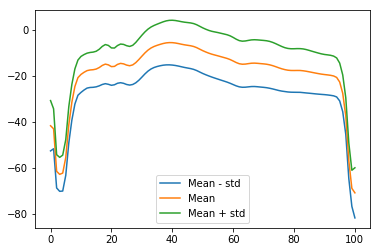

In [65]:
M=COV['Mean']
S=np.sqrt(COV['Var'])
plt.plot(M-S)
plt.plot(M)
plt.plot(M+S)
plt.legend(['Mean - std', 'Mean', 'Mean + std'])
plt.show()

## Eigen Vector Extraction

('shape of E=', (101,), 'shape of NE=', (101,))
Plot for the first 10 Eigen Vectors


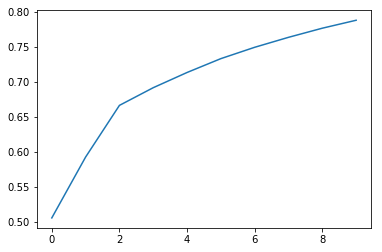

In [68]:
## Get Spectra
spectra=df.rdd.map(trimmed_spectra)

## Extract Eigen Vectors
COV=computeCov(spectra)
eigval,eigvec=LA.eig(COV['Cov'])
eigval=eigval/sum(eigval)

## Check the Reconstruction
print("Plot for the first 10 Eigen Vectors")
plot(cumsum(eigval[:10]))

## Visualizing the first 4 eigen vectors

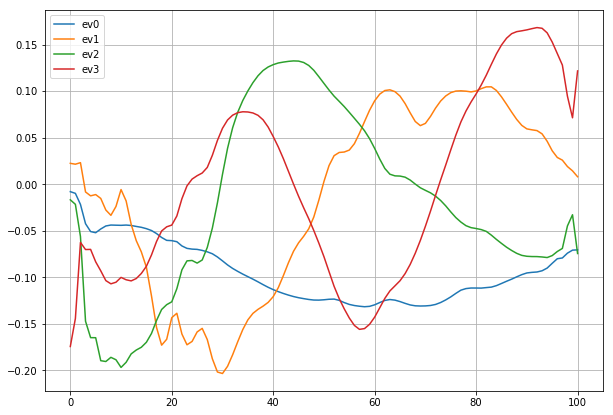

In [48]:
figure(figsize=[10,7])
for i in range(4):
    plot(eigvec[:,i],label='ev'+str(i))
legend()
grid()

In [69]:
sum(eigvec[:,1]**2)

1.0000000000000004

**Observations**: Can be seen that the sum of all eigen vectors is 1

In [72]:
## Using First 10 Eigen Vectors
V=eigvec[:,0:10]
## Defining a function to return Projection
def project(array, V):
    return np.dot(array, V)

## Creating Training Data

In [ ]:
def calc_stats(row):
    array = trimmed_spectra(row)
    projections = project(array)
    rmse = np.std(array)
    peak2peak = row.peak2peak
    label = 0 if row.species==u'Gervais' else 1
    return np.hstack((projections, [rmse, peak2peak, label]))

In [74]:
df_filtered_data = df.rdd.map(calc_stats)

In [53]:
data = df_filtered_data.collect()

## Writing Data

In [54]:
np_data = np.array(data)
np.save(open('data.np', 'wb'), np_data)

## Category Analysis

In [82]:
Cuviers=df.filter(df.TPWS2==1).filter(df.species==u'Cuviers')
Gervais=df.filter(df.TPWS2==1).filter(df.species==u'Gervais')

In [88]:
print("Total: ", Cuviers.count() + Gervais.count())
print("Cuviers: ", Cuviers.count())
print("Gervais: ", Gervais.count())

('Total: ', 4144531)
('Cuviers: ', 2212199)
('Gervais: ', 1932332)


In [83]:
V=eigvec[:,1:3] #vectors on which to project, chose 1,2,3 eigen vectors
def project(row):
    X=unpackArray(row.MSP,data_type=np.float64)
    return np.dot(X,V)

## Scatter Plot
Scatter plot shows there are some points which are classified as a particular species in high confidence and the rest are unsure.

(0, 200)

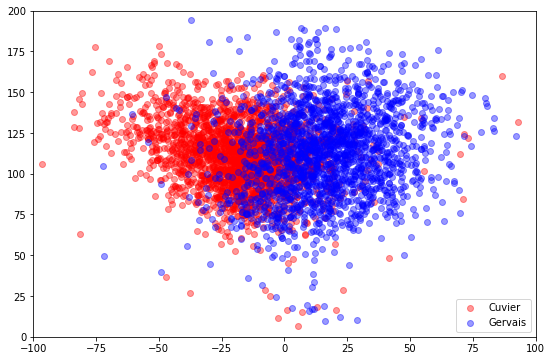

In [105]:
Cuvier_projections=np.array(Cuviers.sample(False,0.001).rdd.map(project).take(10000))
Gervais_projections=np.array(Gervais.sample(False,0.001).rdd.map(project).take(10000))


figure(figsize=[9,6])
scatter(Cuvier_projections[:,0],Cuvier_projections[:,1],c='r', alpha=0.4)
scatter(Gervais_projections[:,0],Gervais_projections[:,1],c='b', alpha=0.4)
legend(['Cuvier', 'Gervais'], loc="lower right")
xlim([-100,100])
ylim([0,200])

## Highlighting the area of importance

(50, 150)

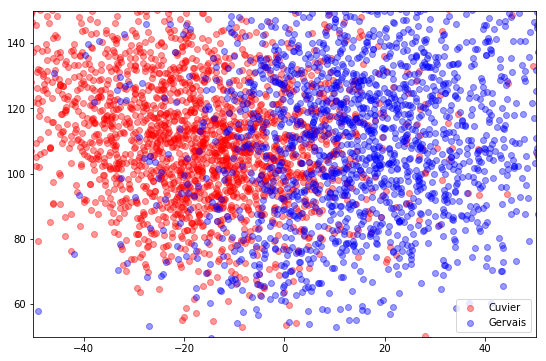

In [104]:
Cuvier_projections=np.array(Cuviers.sample(False,0.001).rdd.map(project).take(10000))
Gervais_projections=np.array(Gervais.sample(False,0.001).rdd.map(project).take(10000))


figure(figsize=[9,6])
scatter(Cuvier_projections[:,0],Cuvier_projections[:,1],c='r', alpha=0.4)
scatter(Gervais_projections[:,0],Gervais_projections[:,1],c='b', alpha=0.4)
legend(['Cuvier', 'Gervais'], loc="lower right")
xlim([-50, 50])
ylim([50, 150])